## Librerias

In [1]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import numpy as np

## Coordenadas baricentricas y cartesianas

Respecto a una triangulación de Delaunay de un conjunto de puntos respecto al simplice k-ésimo.

In [2]:
def barycentric(delaunay,points,k): # k=id simplice
    n = len(points[0])
    b = delaunay.transform[k,:n].dot(np.transpose(points - delaunay.transform[k,n]))
    return np.c_[np.transpose(b), 1 - b.sum(axis=0)]

def cartesian(delaunay,barycentric,k):
    return barycentric.dot(delaunay.points[delaunay.simplices[k]])

Por ejemplo

In [3]:
dataset = (np.array([[0,0],[0,1],[1,0],[1,1],[-1,-1],[-1,2],[2,2],[-1,2],[2,-1]]),
           np.array([0,1,1,0,2,2,2,2,2]))
data = dataset[0]
classes = dataset[1]

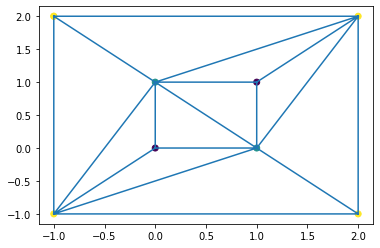

In [4]:
k = Delaunay(data)
plt.triplot(data[:,0], data[:,1], k.simplices)
plt.scatter(data[:,0], data[:,1],c=classes)
plt.show()

In [5]:
# La lista de símplices de la triangulación se obtiene:
k.simplices

array([[0, 1, 4],
       [1, 5, 4],
       [5, 1, 6],
       [1, 3, 6],
       [2, 0, 4],
       [8, 2, 4],
       [2, 1, 0],
       [1, 2, 3],
       [3, 2, 6],
       [2, 8, 6]], dtype=int32)

In [6]:
# La lista de vértices de la triangulación se obtiene:
k.points

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  1.],
       [-1., -1.],
       [-1.,  2.],
       [ 2.,  2.],
       [-1.,  2.],
       [ 2., -1.]])

In [7]:
# Coordenadas baricéntricas de los puntos [(0.2,0.5),(1.7,2.1)] respecto al símplice [5, 1, 6]:
barycentric(k,[(0.2,0.5),(1.7,2.1)],2)

array([[-0.4       ,  1.5       , -0.1       ],
       [ 0.16666667, -0.1       ,  0.93333333]])

### Definición de la red neuronal

In [8]:
def nn(dataset,p):
    data = dataset[0] # LOS PUNTOS
    classes = dataset[1] # CLASES
    k = Delaunay(data) # COMPLEJO K
    l = Delaunay(np.array([[0,0],[0,1],[1,0]])) # COMPLEJO L
    b=barycentric(k,p,k.find_simplex(p)[0]) # BARICENTRICAS DE P EN K
    image = classes[k.simplices[k.find_simplex(p)]][0] 
    # TOMAMOS LAS BARICENTRICAS RESPECTO UNO DE LOS SIMPLICES 
    # A LOS QUE PERTENECE P, ES DECIR, COORDENADAS BARICÉNTRICAS POSITIVAS.
    # VERTICES IMAGEN DEL SIMPLICE QUE CONTIENE A P EN K
    f=b.dot(l.points[image])
    # CARTESIANAS IMAGEN DE P EN L
    return  barycentric(l,f,0) # BARICÉNTRICAS DE P EN L

#### Ejemplo:

Complejo simplicial L

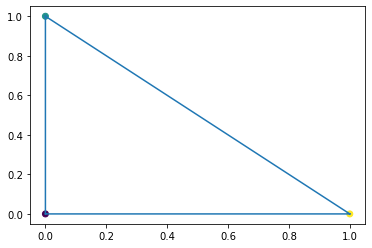

In [9]:
l = Delaunay(np.array([[0,0],[0,1],[1,0]]))
plt.triplot(l.points[:,0], l.points[:,1], l.simplices)
plt.scatter(l.points[:,0],l.points[:,1],c=np.array([0,1,2]))
plt.show()

In [10]:
nn(dataset,[(-0.1,1.1)])

array([[0.1, 0.9, 0. ]])

### Subdivisión baricéntrica

In [11]:
import itertools 

In [12]:
# Auxiliary function: 
# Input: list
# Output: subsets of a given size
def findsubsets(s, n): 
    return np.array(list(itertools.combinations(s, n)))

In [13]:
# Devuelve una 2-upla. El primer elemento es una lista de tuplas con los símplices
# y los índices de sus baricentros. El segundo elemento son todos los nuevos puntos.

# Barycentric subdivision of a given simplex.
# Input: A simplex (simplice in spanish) and points location of the vertices (puntos)
# Output: two lists. The first one is composed of indices of the new vertices
# with the simplices to compute it.
# The second list is composed of the locations of the new points.
def barycentric_subd(simplice,puntos):
    i=len(simplice)
    index = len(puntos)-1
    ls = []
    bs = []
    while i!=1:
        s1= findsubsets(simplice,i)#[0],i)
        b1= [np.sum(puntos[s],axis=0)/i for s in s1]
        xs = []
        for b in b1:
            bs.append(b)
            index+=1
            xs.append(index) 
        ls.append(np.array(list(zip(xs,s1))))
        i-=1
    s_ori= findsubsets(simplice,1)
    ls.append(np.array(list(zip(simplice,s_ori))))
    return (np.concatenate(ls),bs)


In [14]:
# Use the output of barycentric subdivision function to provide the maximal
# simplices of the barycentric subdivision.
# Input: output of barycentric subdivision and dimension of the maximal simplices     
def maximal_simp(t,dim):
    t1=t[0]
    lists = findsubsets(t1,dim+1)
    simps = []
    for l in lists:
        if ite_sublist(l[:,1]):
            simps.append(l[:,0])
    return simps
        
#Auxiliary function to check if a list lst1 is contained in other list lst2
def sublist(lst1, lst2):
    return (set(lst1) <= set(lst2))
 
# Generalization of the function of list to a sequence of lists.
def ite_sublist(ts):
    ls = []
    for i in range(len(ts)):
        a = all([sublist(ts[j],ts[i]) for j in range(i+1,len(ts))])
        ls.append(a)
    return all(ls)
        

# Barycentric subdivision of a simplicial complex.
def bar_subd_complex(simp_complex,puntos):
    ss = []
    p = puntos
    dim=len(simp_complex[0])-1
    for i in range(np.shape(simp_complex)[0]):
        b=barycentric_subd(simp_complex[i],p)
        m = maximal_simp(b,dim)
        p = np.concatenate((p,b[1]))
        ss.append(m)
    return((np.array(np.concatenate(ss),dtype=np.int),p))
        

#### Ejemplo

<ipython-input-13-0c7291b33819>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ls.append(np.array(list(zip(xs,s1))))
<ipython-input-13-0c7291b33819>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ls.append(np.array(list(zip(simplice,s_ori))))


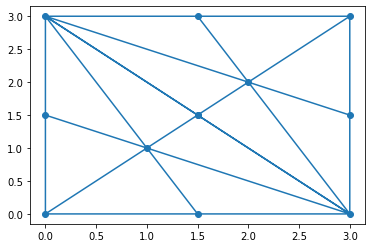

In [15]:
p = np.array([[0,3],[3,0],[0,0],[3,3]])
simplices = np.array([[0,1,2],[0,1,3]])

b=bar_subd_complex(simplices,p)
plt.triplot(b[1][:,0], b[1][:,1], b[0])
plt.scatter(b[1][:,0], b[1][:,1])
plt.show()

In [16]:
b

(array([[ 4,  5,  0],
        [ 4,  5,  1],
        [ 4,  6,  0],
        [ 4,  6,  2],
        [ 4,  7,  1],
        [ 4,  7,  2],
        [ 8,  9,  0],
        [ 8,  9,  1],
        [ 8, 10,  0],
        [ 8, 10,  3],
        [ 8, 11,  1],
        [ 8, 11,  3]]),
 array([[0. , 3. ],
        [3. , 0. ],
        [0. , 0. ],
        [3. , 3. ],
        [1. , 1. ],
        [1.5, 1.5],
        [0. , 1.5],
        [1.5, 0. ],
        [2. , 2. ],
        [1.5, 1.5],
        [1.5, 3. ],
        [3. , 1.5]]))

# Embedding

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()

In [18]:
len(digits.data)

1797

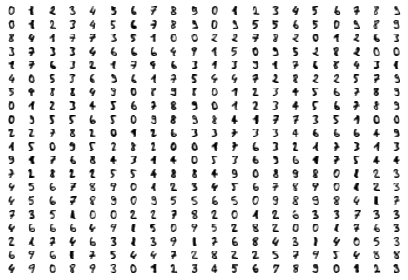

In [19]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)


In [20]:
import umap

In [21]:
reducer = umap.UMAP()
reducer.fit(digits.data)
umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
embedding = reducer.transform(digits.data)
embedding.shape

(1797, 2)

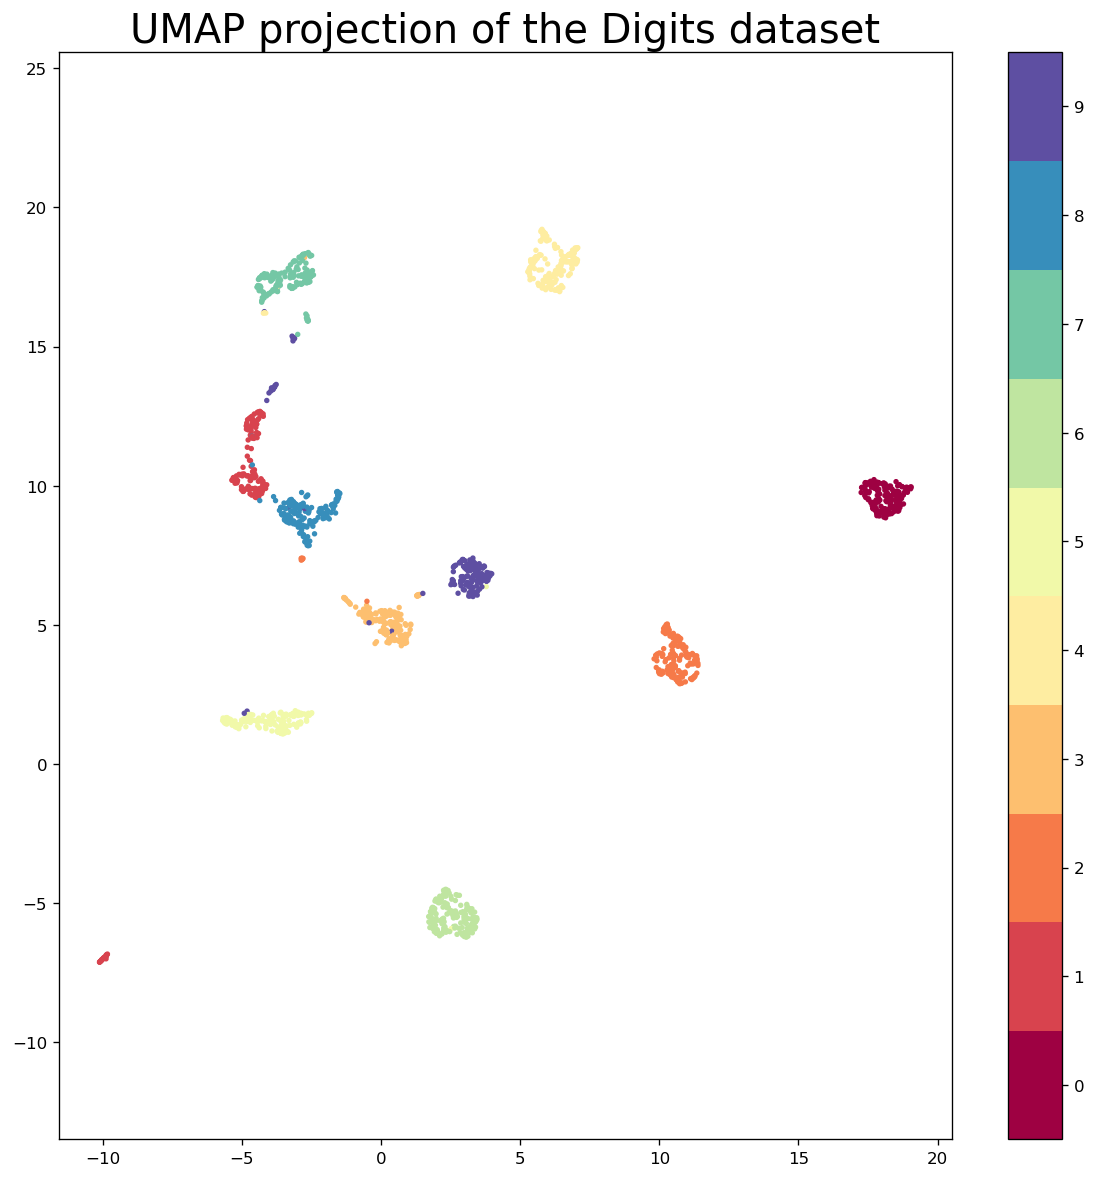

In [22]:
plt.figure(figsize=(12, 12), dpi=120)
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);


### Triangulation

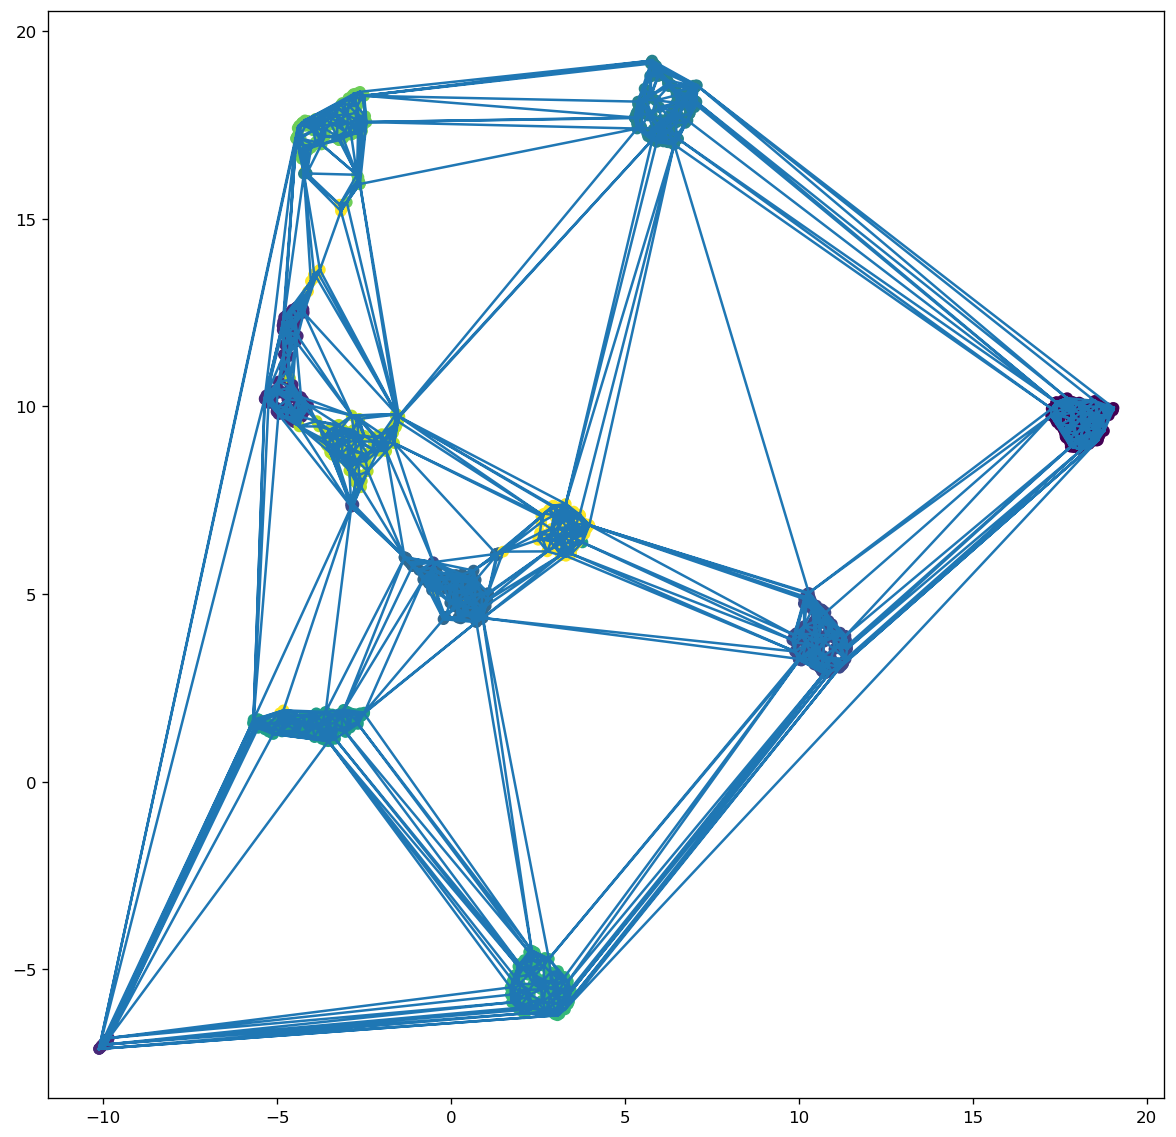

In [23]:
k = Delaunay(embedding)
plt.figure(figsize=(12, 12), dpi=120)
plt.scatter(embedding[:,0],embedding[:,1],c=digits.target)
plt.triplot(embedding[:,0], embedding[:,1], k.simplices)
plt.show()

Veamos ahora tomando un subconjunto como entrenamiento y otro como validación. Es decir, no todos los puntos serán nodo para Delaunay. La clase 10 será la "desconocida".

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding, digits.target, test_size=0.33, random_state=42)
# Tenemos que añadir una envolvente convexa.
p1 = [np.max(X_train[:,0])+1,np.max(X_train[:,1])+1]
p2 = [np.max(X_train[:,0])+1,np.min(X_train[:,1])-1]
p3 = [np.min(X_train[:,0])-1,np.min(X_train[:,1])-1]
p4 = [np.min(X_train[:,0])-1,np.max(X_train[:,1])+1]
X_train=np.concatenate((X_train,np.array([p1,p2,p3,p4])))
y_train=np.concatenate((y_train,np.array([10,10,10,10])))
k_train = Delaunay(X_train)
X_total= np.concatenate((X_train,X_test))
y_total= np.concatenate((y_train,y_test))
k=Delaunay(X_total)

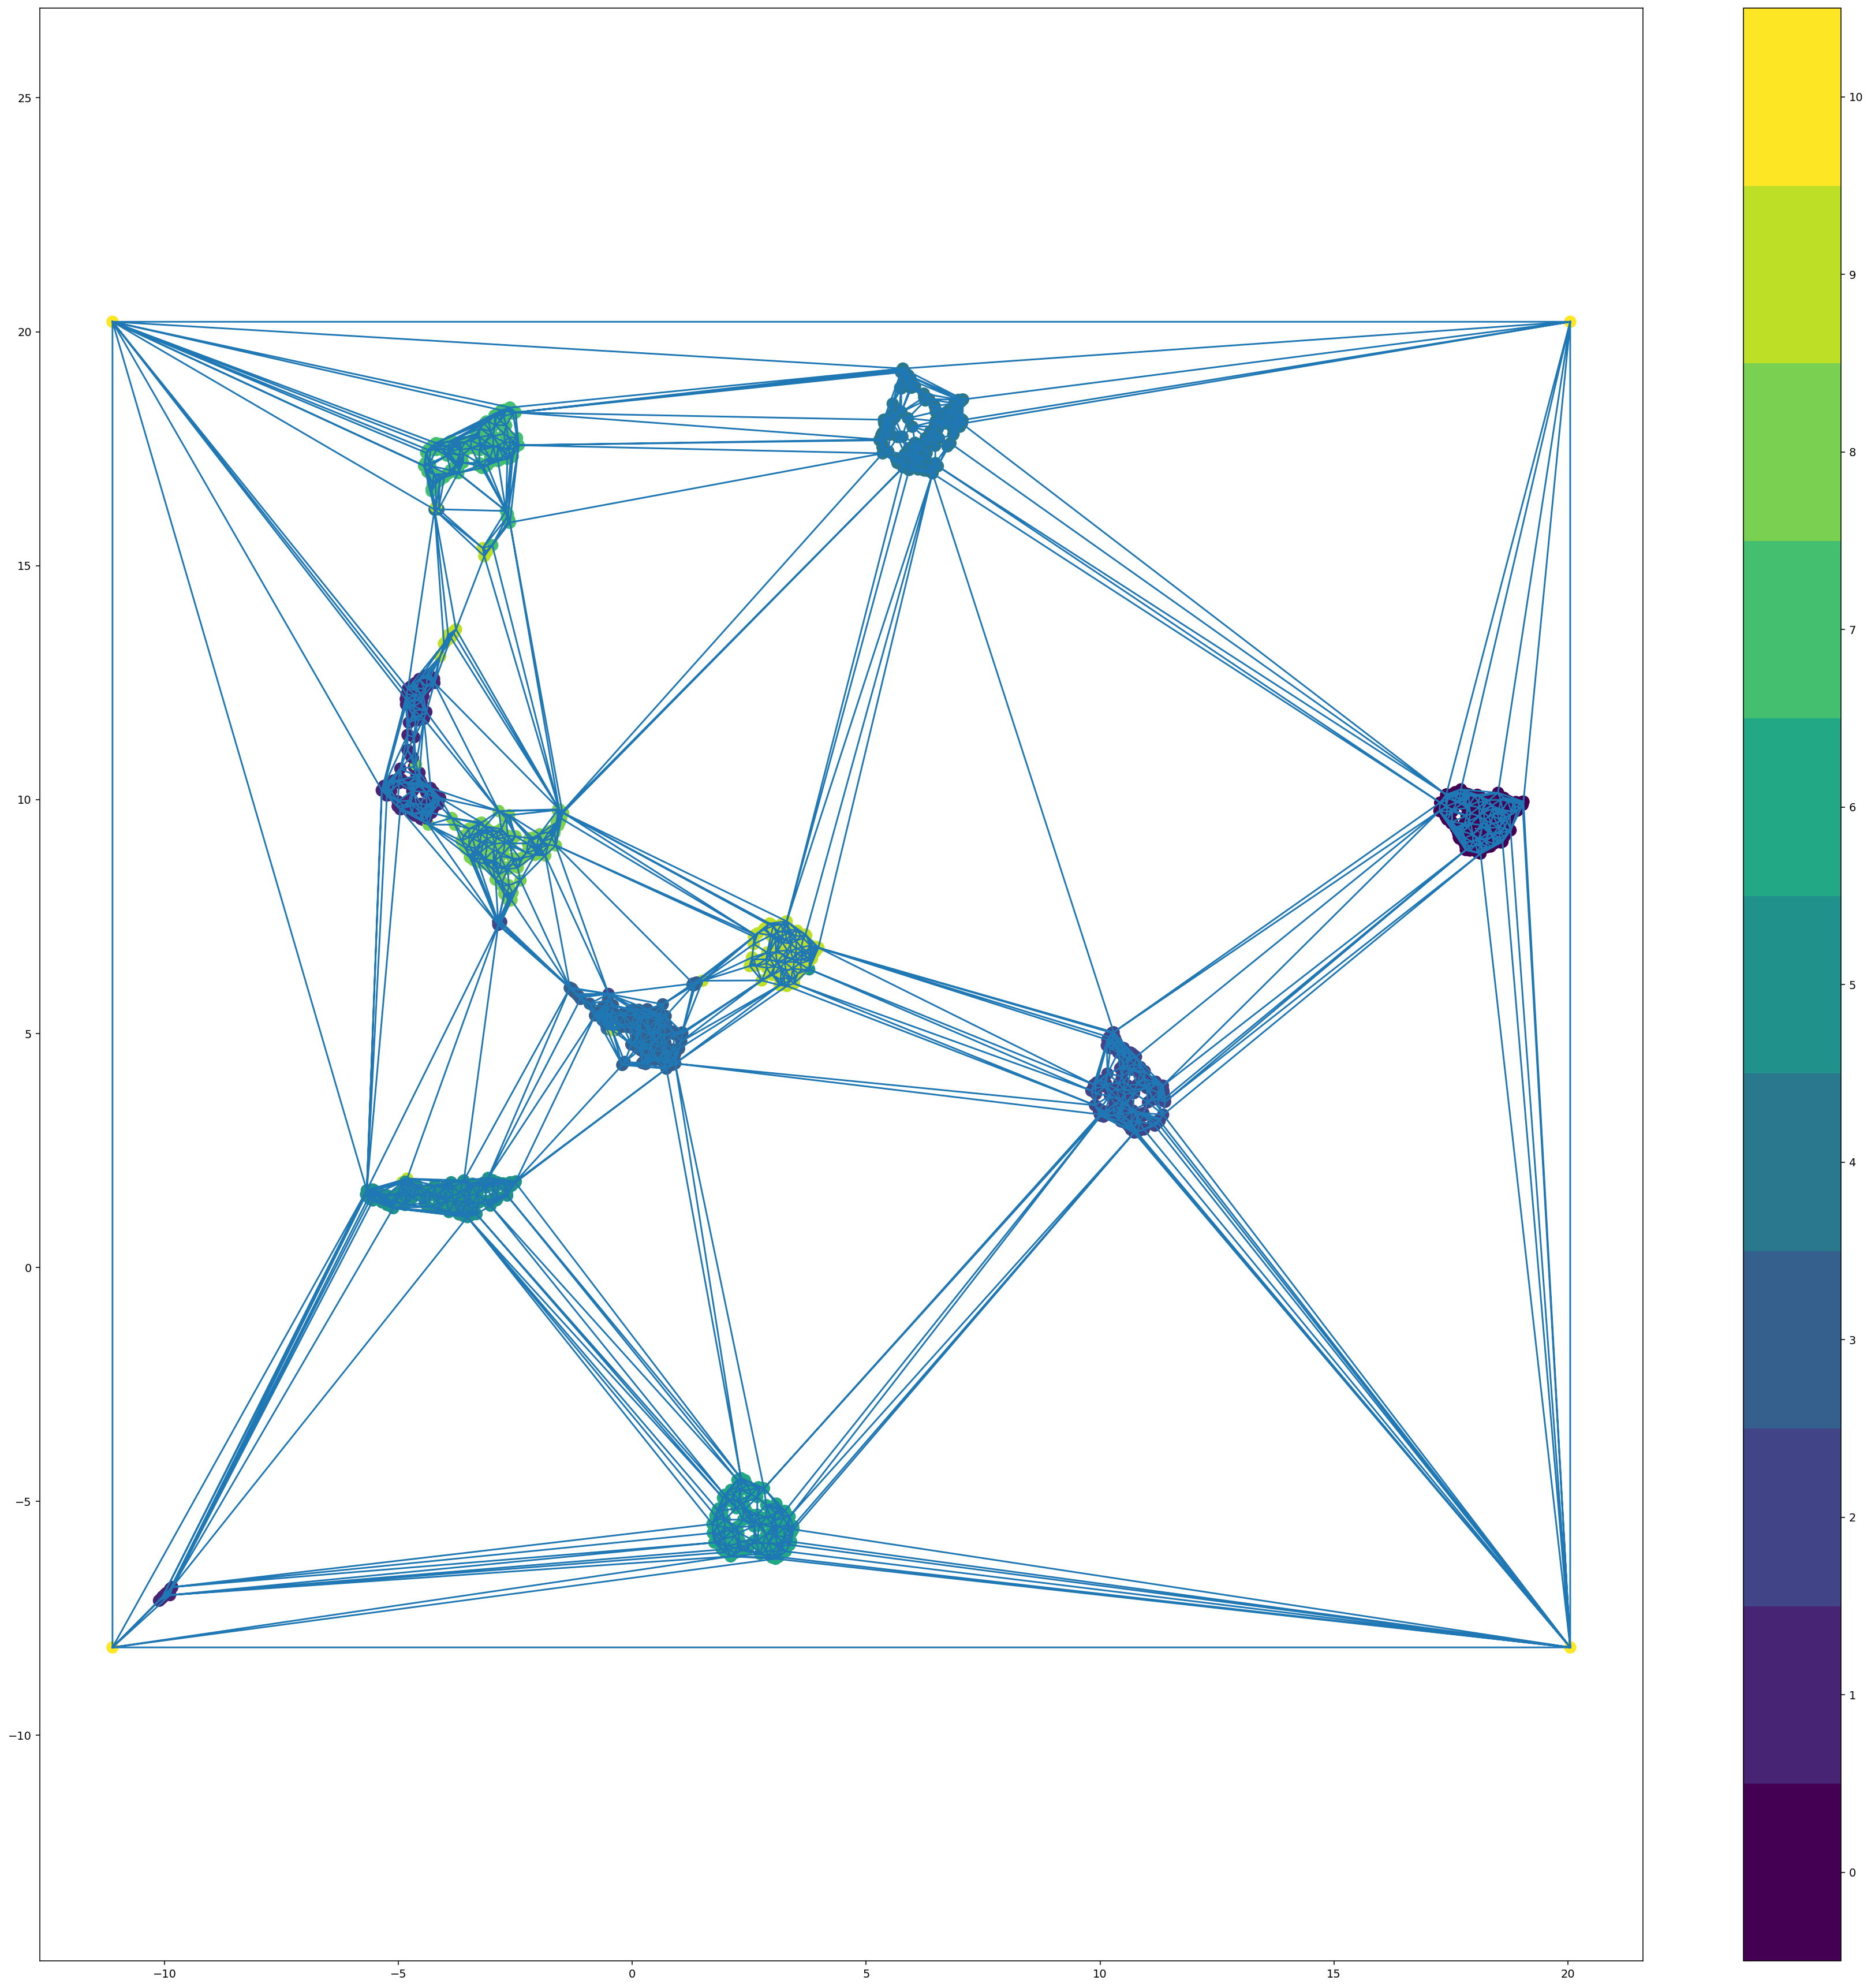

In [33]:
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(X_total[:,0],X_total[:,1],c=y_total,s=100)
plt.triplot(X_total[:,0], X_total[:,1], k.simplices)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))
plt.show()

In [26]:
X_total[y_total==0]

array([[18.31131935,  9.43658829],
       [17.28791046,  9.94028473],
       [18.72822189,  9.97031498],
       [17.60490799,  9.38945866],
       [17.39686966,  9.85544205],
       [17.38332748,  9.64386845],
       [17.8190918 ,  9.87652302],
       [18.58649635,  9.56071568],
       [18.53269386,  9.75084972],
       [18.08749008,  9.95563412],
       [18.88770294,  9.94860649],
       [18.21392822,  9.94735241],
       [17.8265934 ,  9.08955002],
       [17.90569687,  8.91252136],
       [18.54571152,  9.40645981],
       [17.8846302 , 10.11316681],
       [18.57836914,  9.69697189],
       [18.00556564, 10.07326317],
       [18.02859497,  9.03459644],
       [17.76774216,  9.18258572],
       [18.40557861,  9.68985081],
       [18.41750336,  9.05964661],
       [17.6898613 ,  9.96845436],
       [18.1715641 ,  8.96843147],
       [18.60578346,  9.14780331],
       [18.32206154,  9.39896011],
       [18.30888748,  9.98849297],
       [18.64634132,  9.39015293],
       [17.60840988,

## Quitar aquellos triángulos con vértices en misma clase

Originalmente eran  3596  triángulos y  1801  puntos.


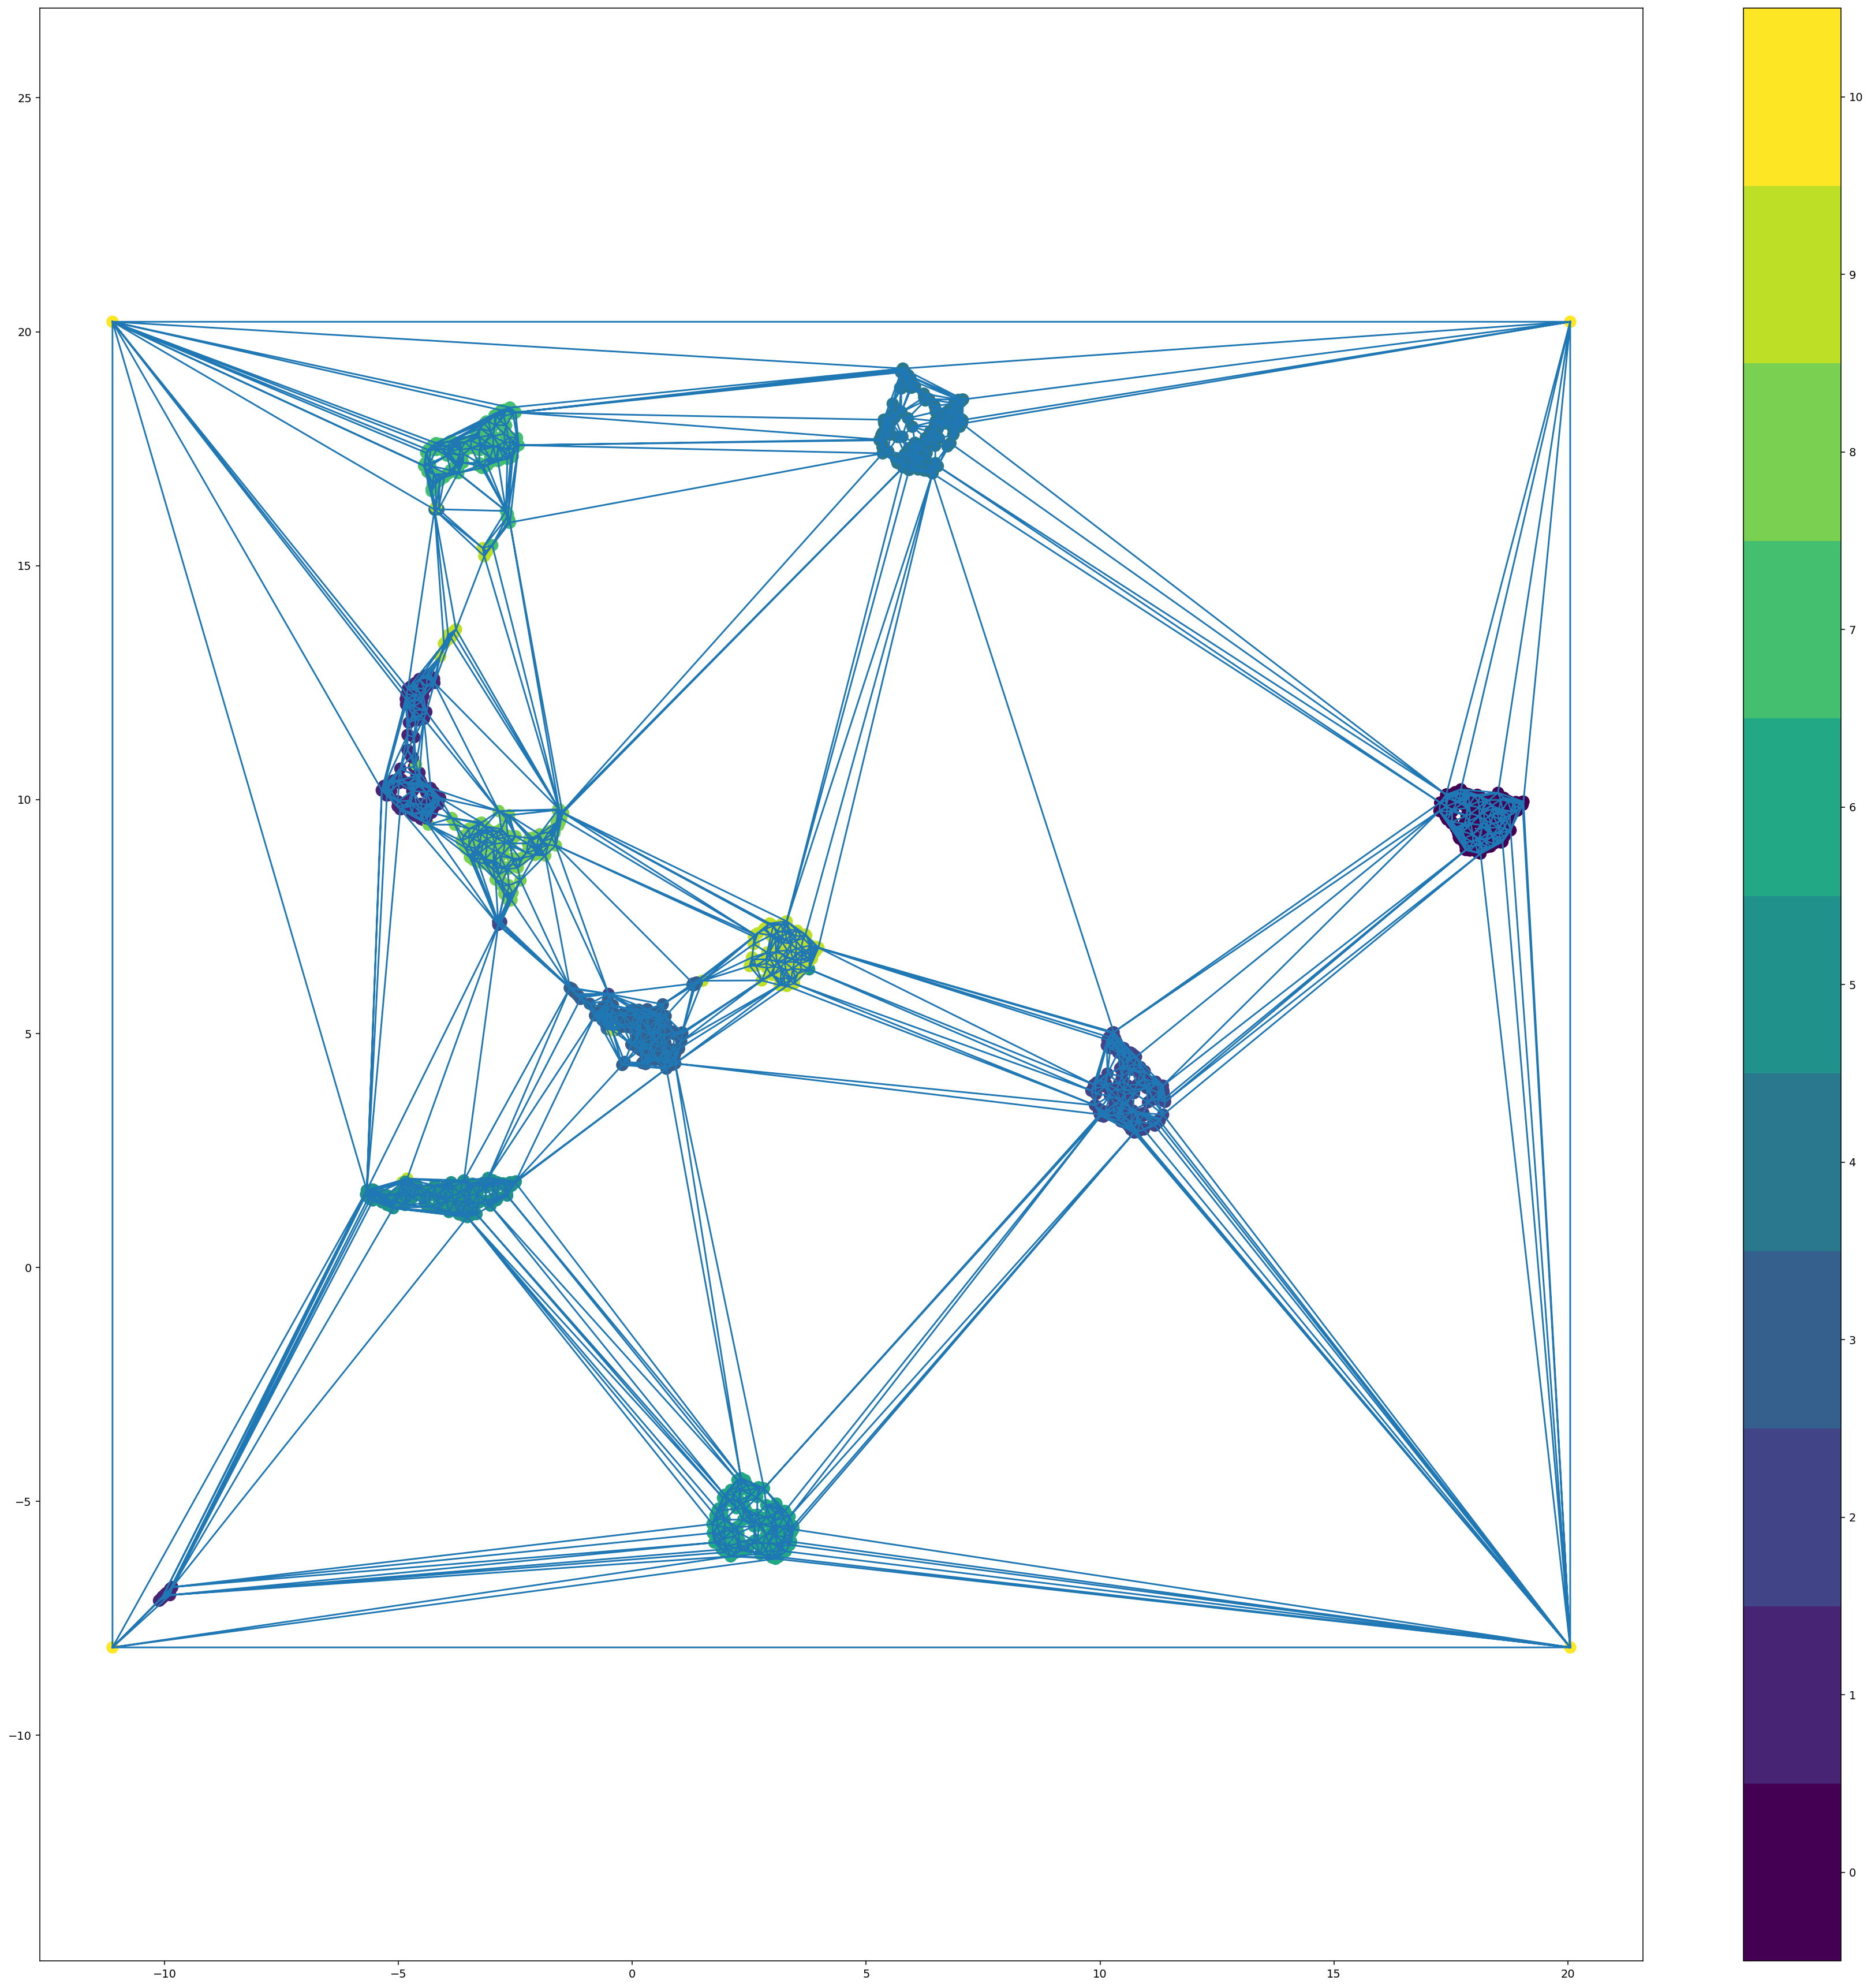

In [34]:
print("Originalmente eran ",len(k.simplices)," triángulos y ",len(k.points)," puntos.")
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(X_total[:,0],X_total[:,1],c=y_total,s=100)
plt.triplot(X_total[:,0], X_total[:,1], k.simplices)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))
plt.show()

Originalmente eran  3596  triángulos y  1801  puntos.


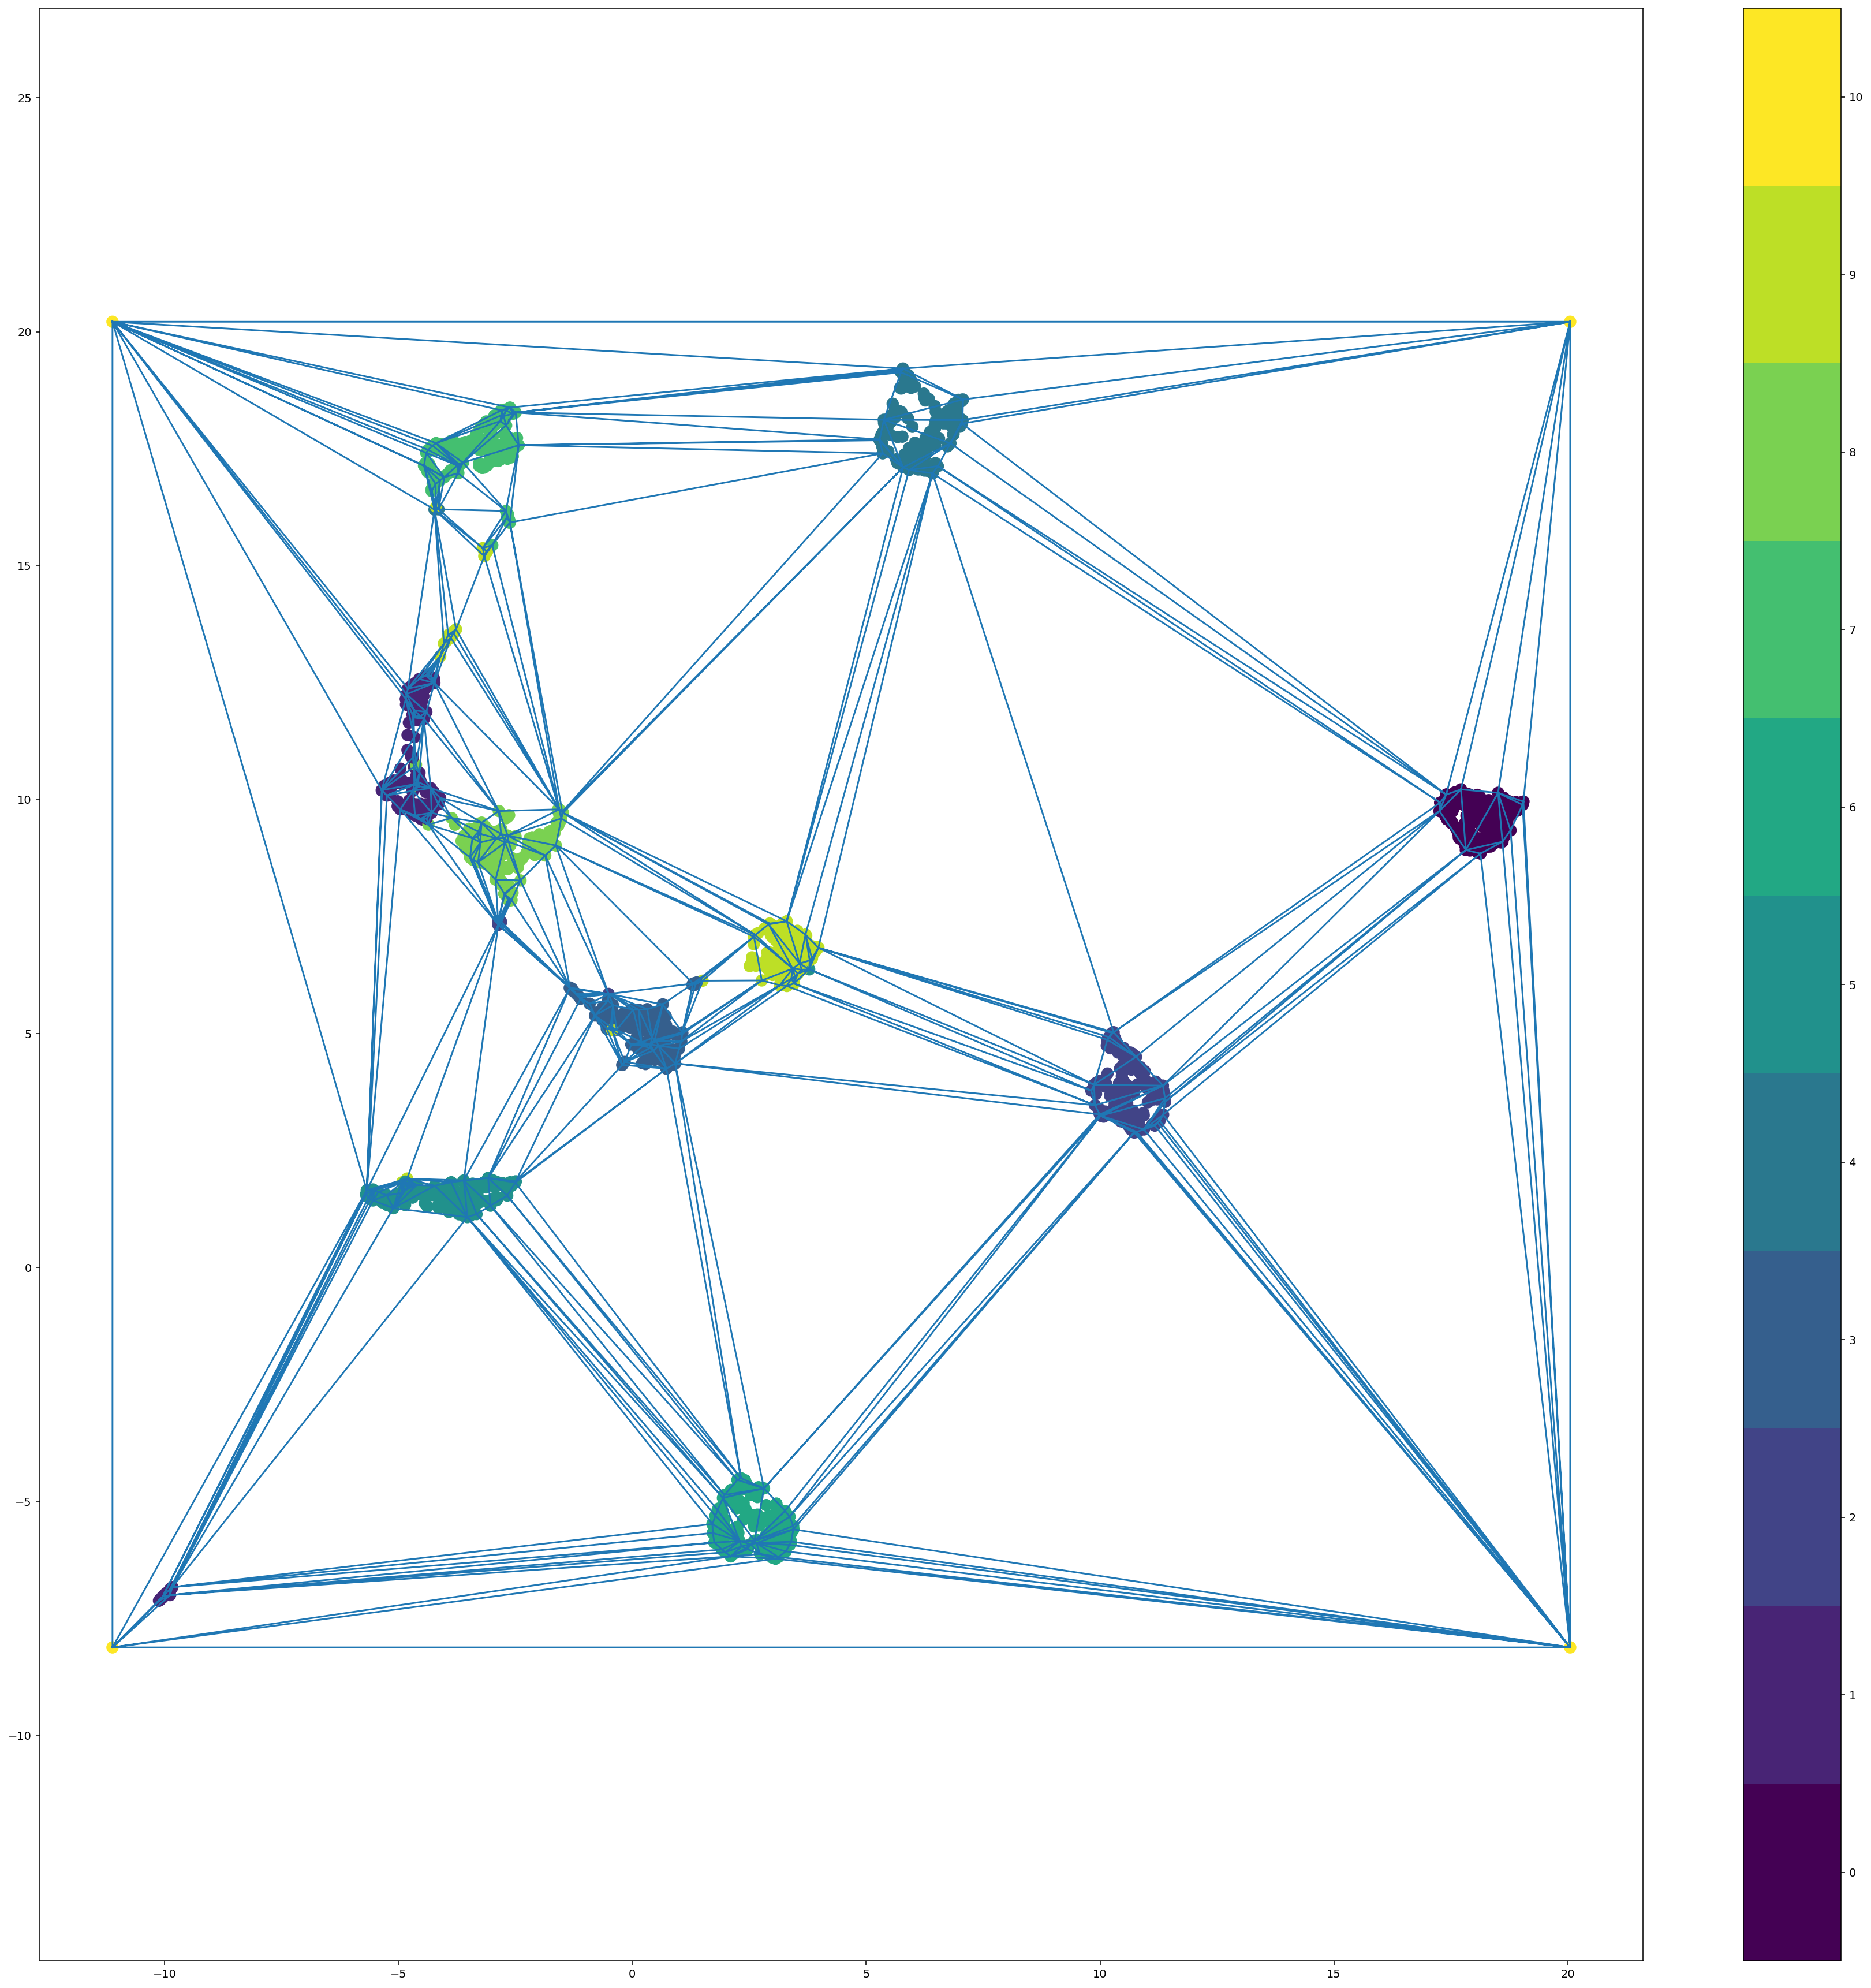

Son  616  triángulos en total.
Son  311  puntos en total.


In [36]:
k=Delaunay(X_total)
print("Originalmente eran ",len(k.simplices)," triángulos y ",len(k.points)," puntos.")
pairs = zip(y_total[k.simplices],k.simplices)
triangulos=[y for (x,y) in pairs if len(set(x))!=1]
k.simplices=triangulos
puntos=k.points[np.unique(k.simplices)]
labels_puntos = y_total[np.unique(k.simplices)]
tr = Delaunay(puntos)
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(X_total[:,0],X_total[:,1],c=y_total,s=100)
plt.triplot(puntos[:,0], puntos[:,1], tr.simplices)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))
plt.show()
print("Son ",len(tr.simplices), " triángulos en total.")
print("Son ",len(tr.points), " puntos en total.")

In [47]:
np.concatenate((X_train[::-4],X_test))

array([[-11.11347961,  20.21384048],
       [ -4.66011572,  10.32880878],
       [  0.44085753,   5.44779253],
       ...,
       [  6.64796829,  18.04335785],
       [  3.64719701,   6.67867661],
       [ 17.79986572,   9.0974369 ]])

In [54]:
np.where(labels_puntos!=10)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

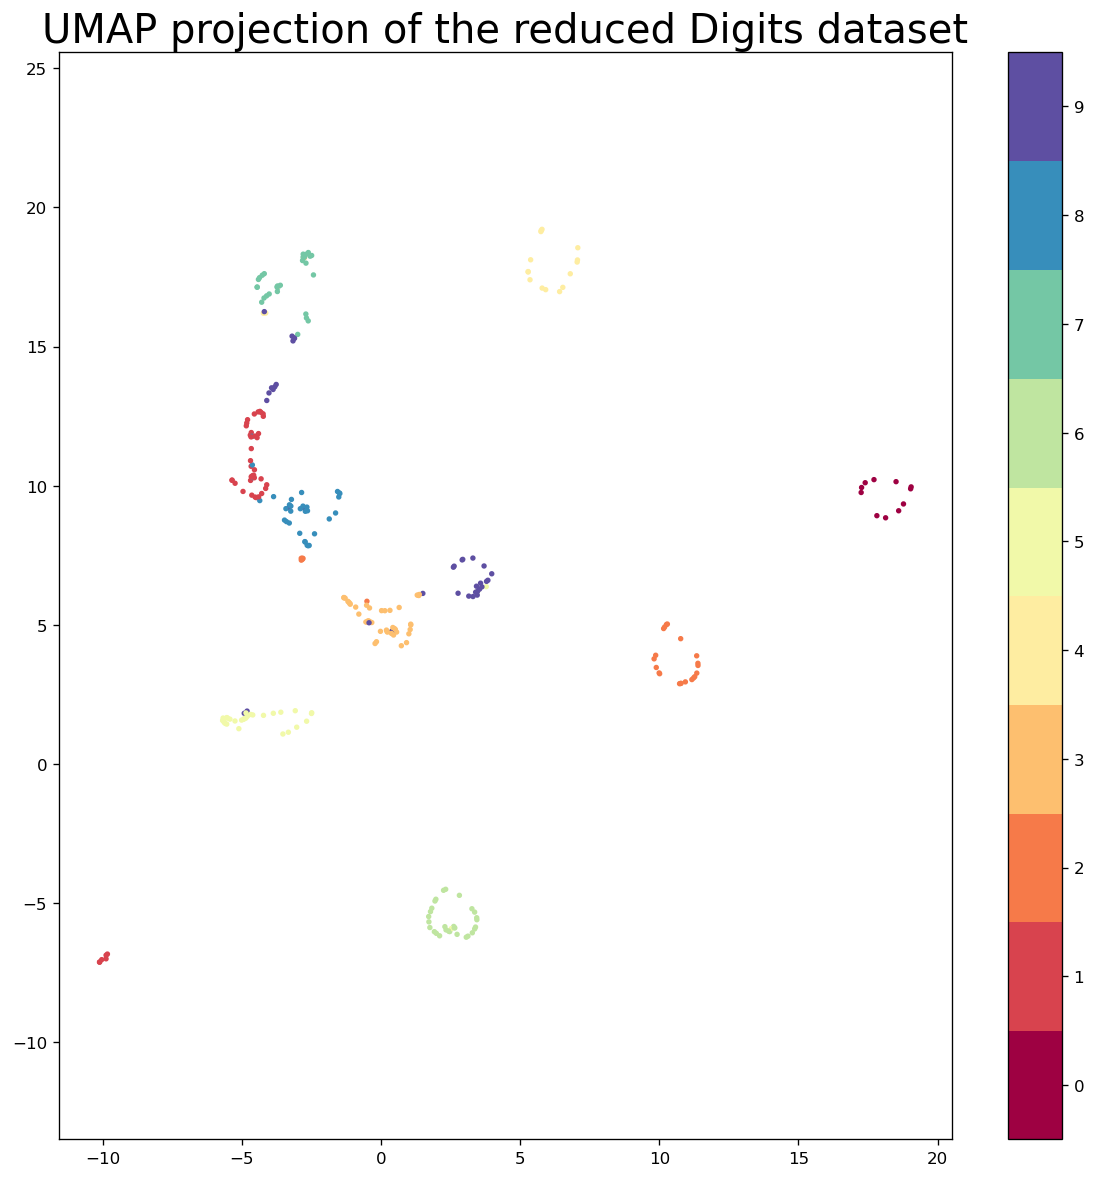

In [56]:
plt.figure(figsize=(12, 12), dpi=120)
plt.scatter(puntos[np.where(labels_puntos!=10)][:, 0], puntos[np.where(labels_puntos!=10)][:, 1], c=labels_puntos[np.where(labels_puntos!=10)], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the reduced Digits dataset', fontsize=24);

In [29]:
def nn(dataset,p):
    data = dataset[0] # LOS PUNTOS
    classes = dataset[1] # CLASES
    k = Delaunay(data) # COMPLEJO K
    n = len(set(classes))
    c=np.zeros(n)
    d=np.diag(np.ones(n))
    ls = []
    ls.append(c)
    for i in range(n):
        ls.append(d[i])
    l = Delaunay(ls) # COMPLEJO L
    b=barycentric(k,p,k.find_simplex(p)[0]) # BARICENTRICAS DE P EN K
    image = classes[k.simplices[k.find_simplex(p)]][0] 
    # TOMAMOS LAS BARICENTRICAS RESPECTO UNO DE LOS SIMPLICES 
    # A LOS QUE PERTENECE P, ES DECIR, COORDENADAS BARICÉNTRICAS POSITIVAS.
    # VERTICES IMAGEN DEL SIMPLICE QUE CONTIENE A P EN K
    f=b.dot(l.points[image])
    # CARTESIANAS IMAGEN DE P EN L
    return  barycentric(l,f,0) # BARICÉNTRICAS DE P EN L

In [30]:
def nn_simplified(dataset,p):
    data = dataset[0] # LOS PUNTOS
    classes = dataset[1] # CLASES
    k = Delaunay(data) # COMPLEJO K
    ## SIMPLIFICACIÓN
    pairs = zip(classes[k.simplices],k.simplices)
    triangulos=[y for (x,y) in pairs if len(set(x))!=1]
    k.simplices=np.array(triangulos)
    puntos=k.points[np.unique(k.simplices)]
    classes_simp=classes[np.unique(k.simplices)]
    k=Delaunay(puntos)
    n = len(set(classes))
    c=np.zeros(n)
    d=np.diag(np.ones(n))
    ls = []
    ls.append(c)
    for i in range(n):
        ls.append(d[i])
    l = Delaunay(ls) # COMPLEJO L
    b=barycentric(k,p,k.find_simplex(p)[0]) # BARICENTRICAS DE P EN K   
    image = classes_simp[k.simplices[k.find_simplex(p)]][0] 
    # TOMAMOS LAS BARICENTRICAS RESPECTO UNO DE LOS SIMPLICES 
    # A LOS QUE PERTENECE P, ES DECIR, COORDENADAS BARICÉNTRICAS POSITIVAS.
    # VERTICES IMAGEN DEL SIMPLICE QUE CONTIENE A P EN K
    f=b.dot(l.points[image])
    # CARTESIANAS IMAGEN DE P EN L
    return  barycentric(l,f,0) # BARICÉNTRICAS DE P EN L

## Comprobación

In [31]:
ls = []
for i in range(len(X_total)):
    ls.append(nn([X_total,y_total],[X_total[i]])==nn_simplified([X_total,y_total],[X_total[i]]))

In [32]:
np.where([all(x)==False for x in np.concatenate(ls)])

(array([   7,   46,   60,   92,   98,  137,  201,  262,  296,  364,  392,
         393,  403,  407,  440,  451,  513,  526,  527,  615,  640,  722,
         728,  809,  962,  983, 1020, 1041, 1115, 1215, 1242, 1280, 1296,
        1321, 1353, 1391, 1414, 1456, 1457, 1469, 1546, 1576, 1660, 1725,
        1734], dtype=int64),)

In [33]:
nn([X_total,y_total],[X_total[4]])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [34]:
nn_simplified([X_total,y_total],[X_total[4]])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

## Gráficos y ejemplos

In [138]:
from sklearn.datasets import make_classification

In [142]:
data = make_classification(n_samples=20, n_features=2,n_informative=1,n_redundant=0,n_clusters_per_class=1,random_state=1)
dataset = data[0]
p1 = [np.max(dataset[:,0])+0.5,np.max(dataset[:,1])+0.5]
p2 = [np.max(dataset[:,0])+0.5,np.min(dataset[:,1])-0.5]
p3 = [np.min(dataset[:,0])-0.5,np.min(dataset[:,1])-0.5]
p4 = [np.min(dataset[:,0])-0.5,np.max(dataset[:,1])+0.5]
labels=np.concatenate((data[1],[2]*4))
dataset= np.concatenate((dataset,[p1,p2,p3,p4]))
k = Delaunay(dataset)

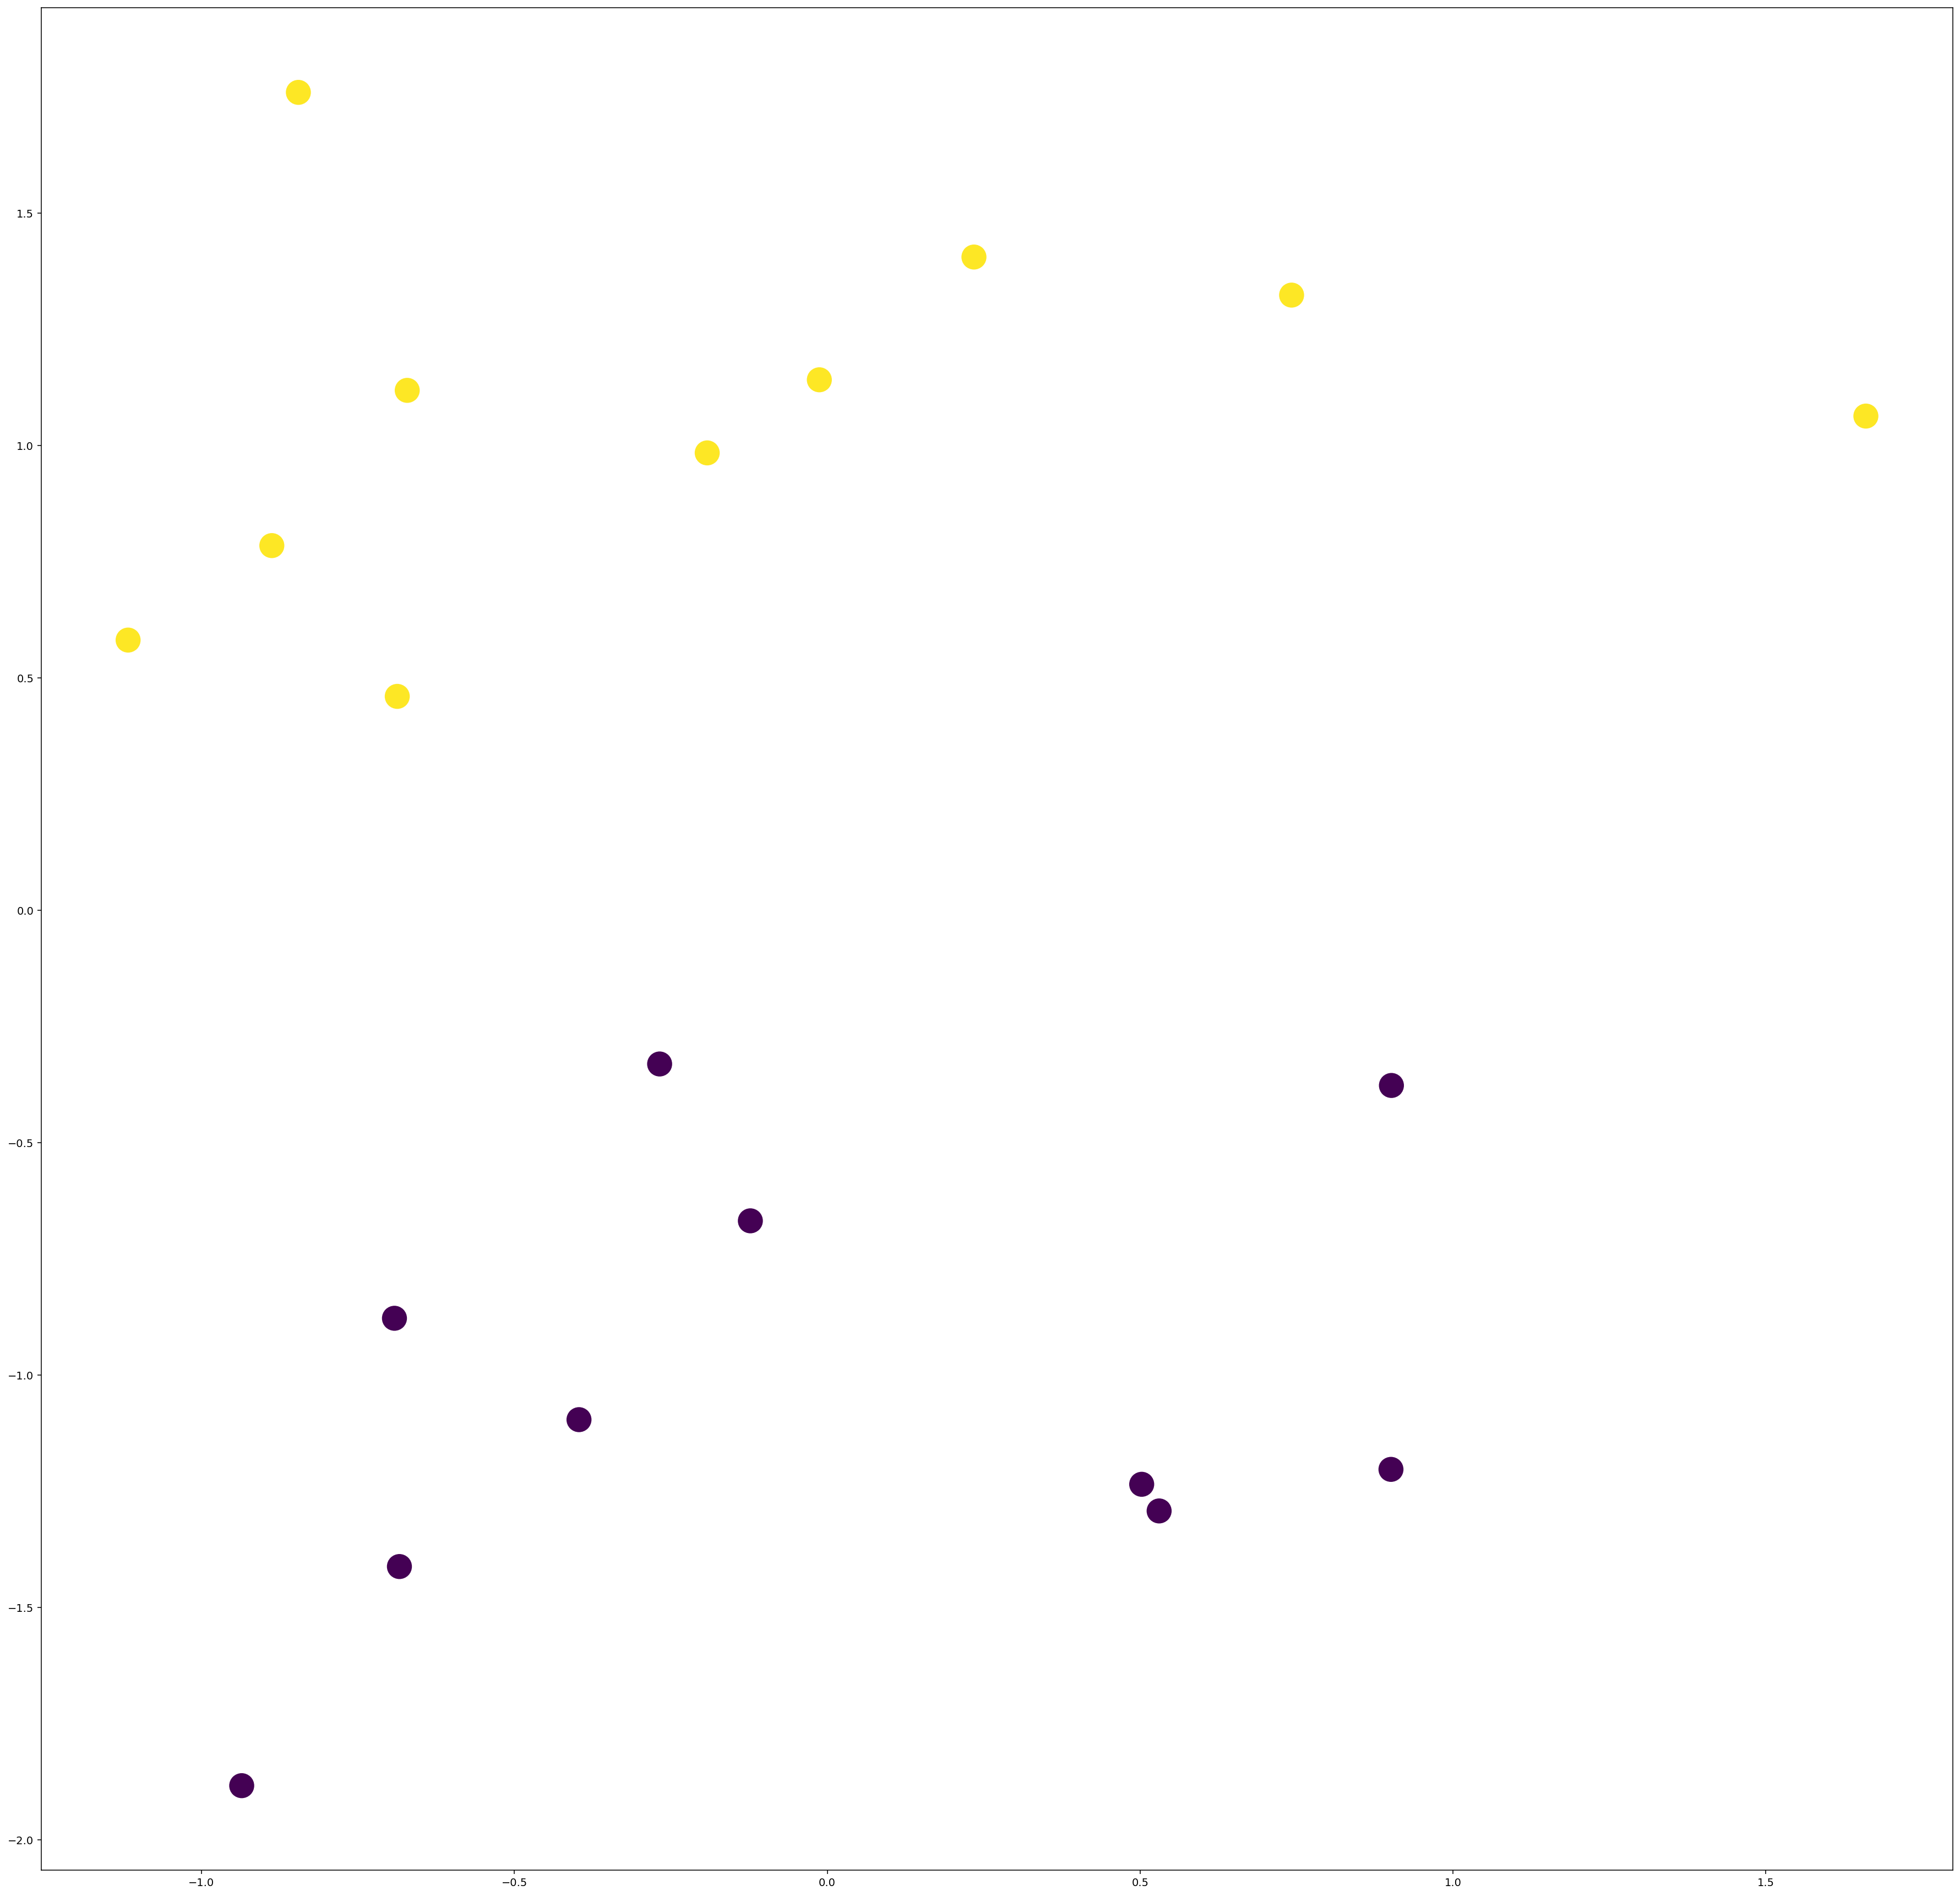

In [147]:
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(data[0][:,0],data[0][:,1],c=data[1],s=500)

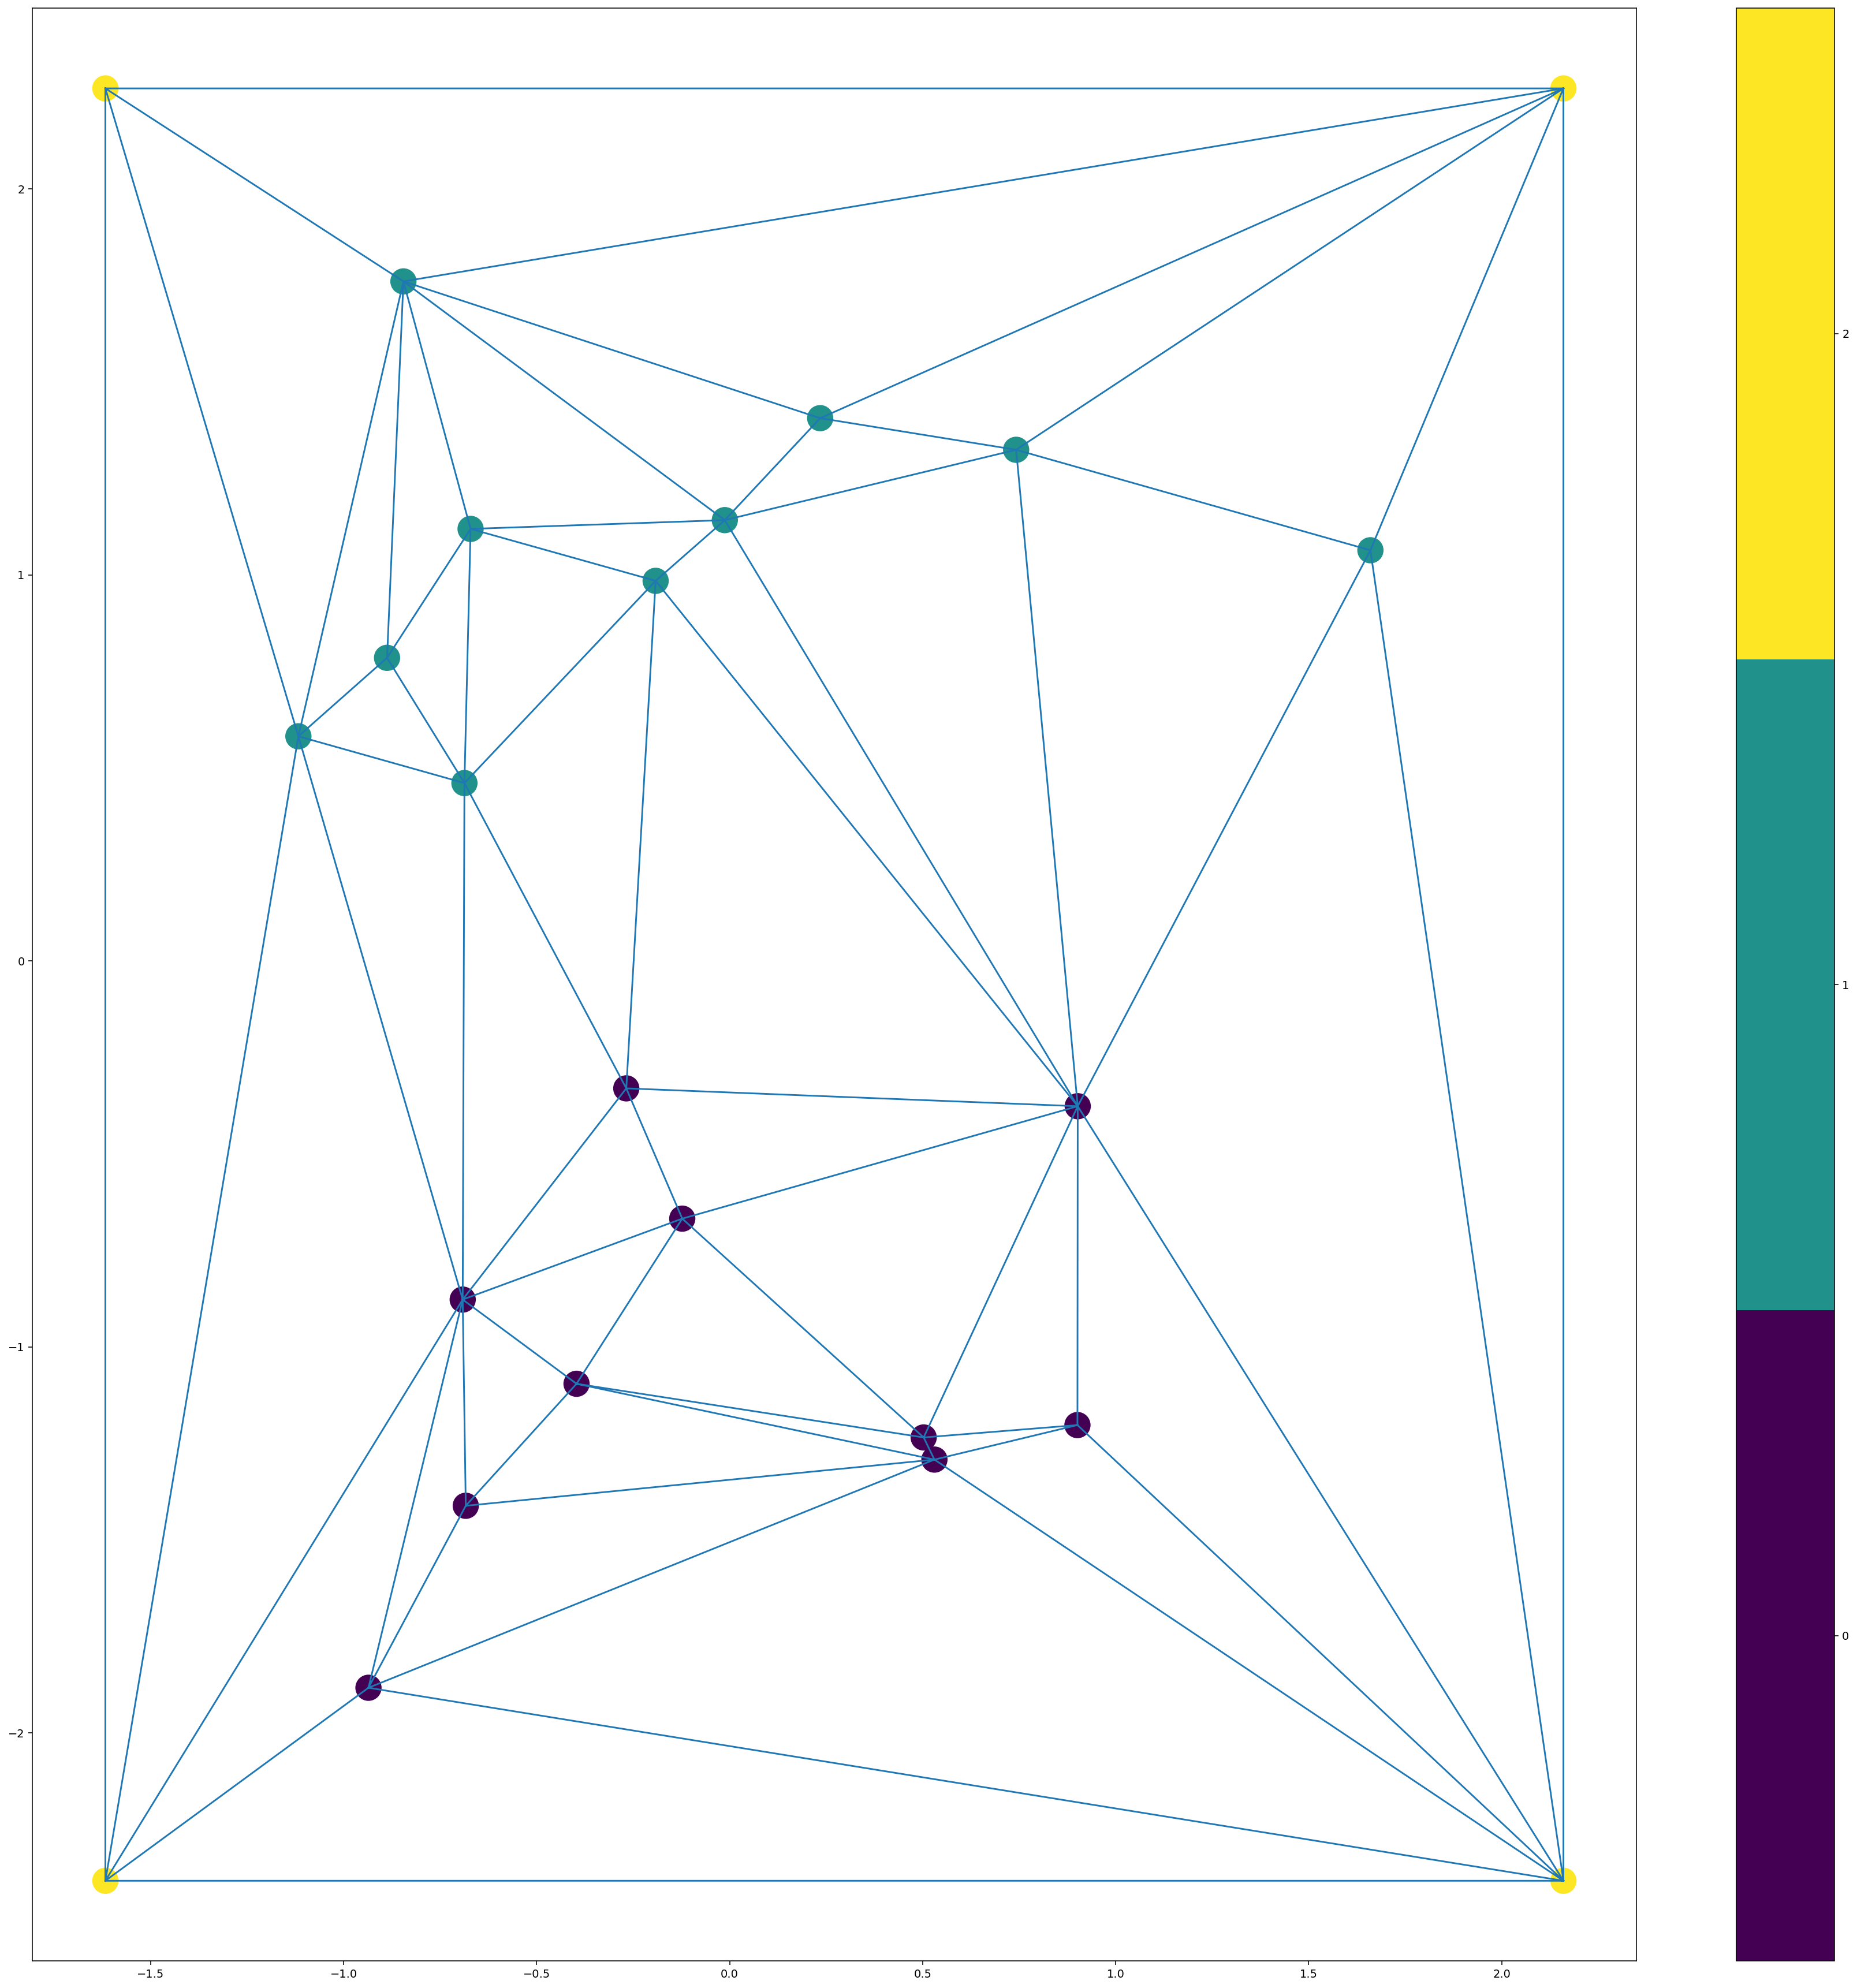

In [143]:
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(dataset[:,0],dataset[:,1],c=labels,s=500)
plt.triplot(dataset[:,0], dataset[:,1], k.simplices)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
plt.show()

Originalmente eran  42  triángulos y  24  puntos.


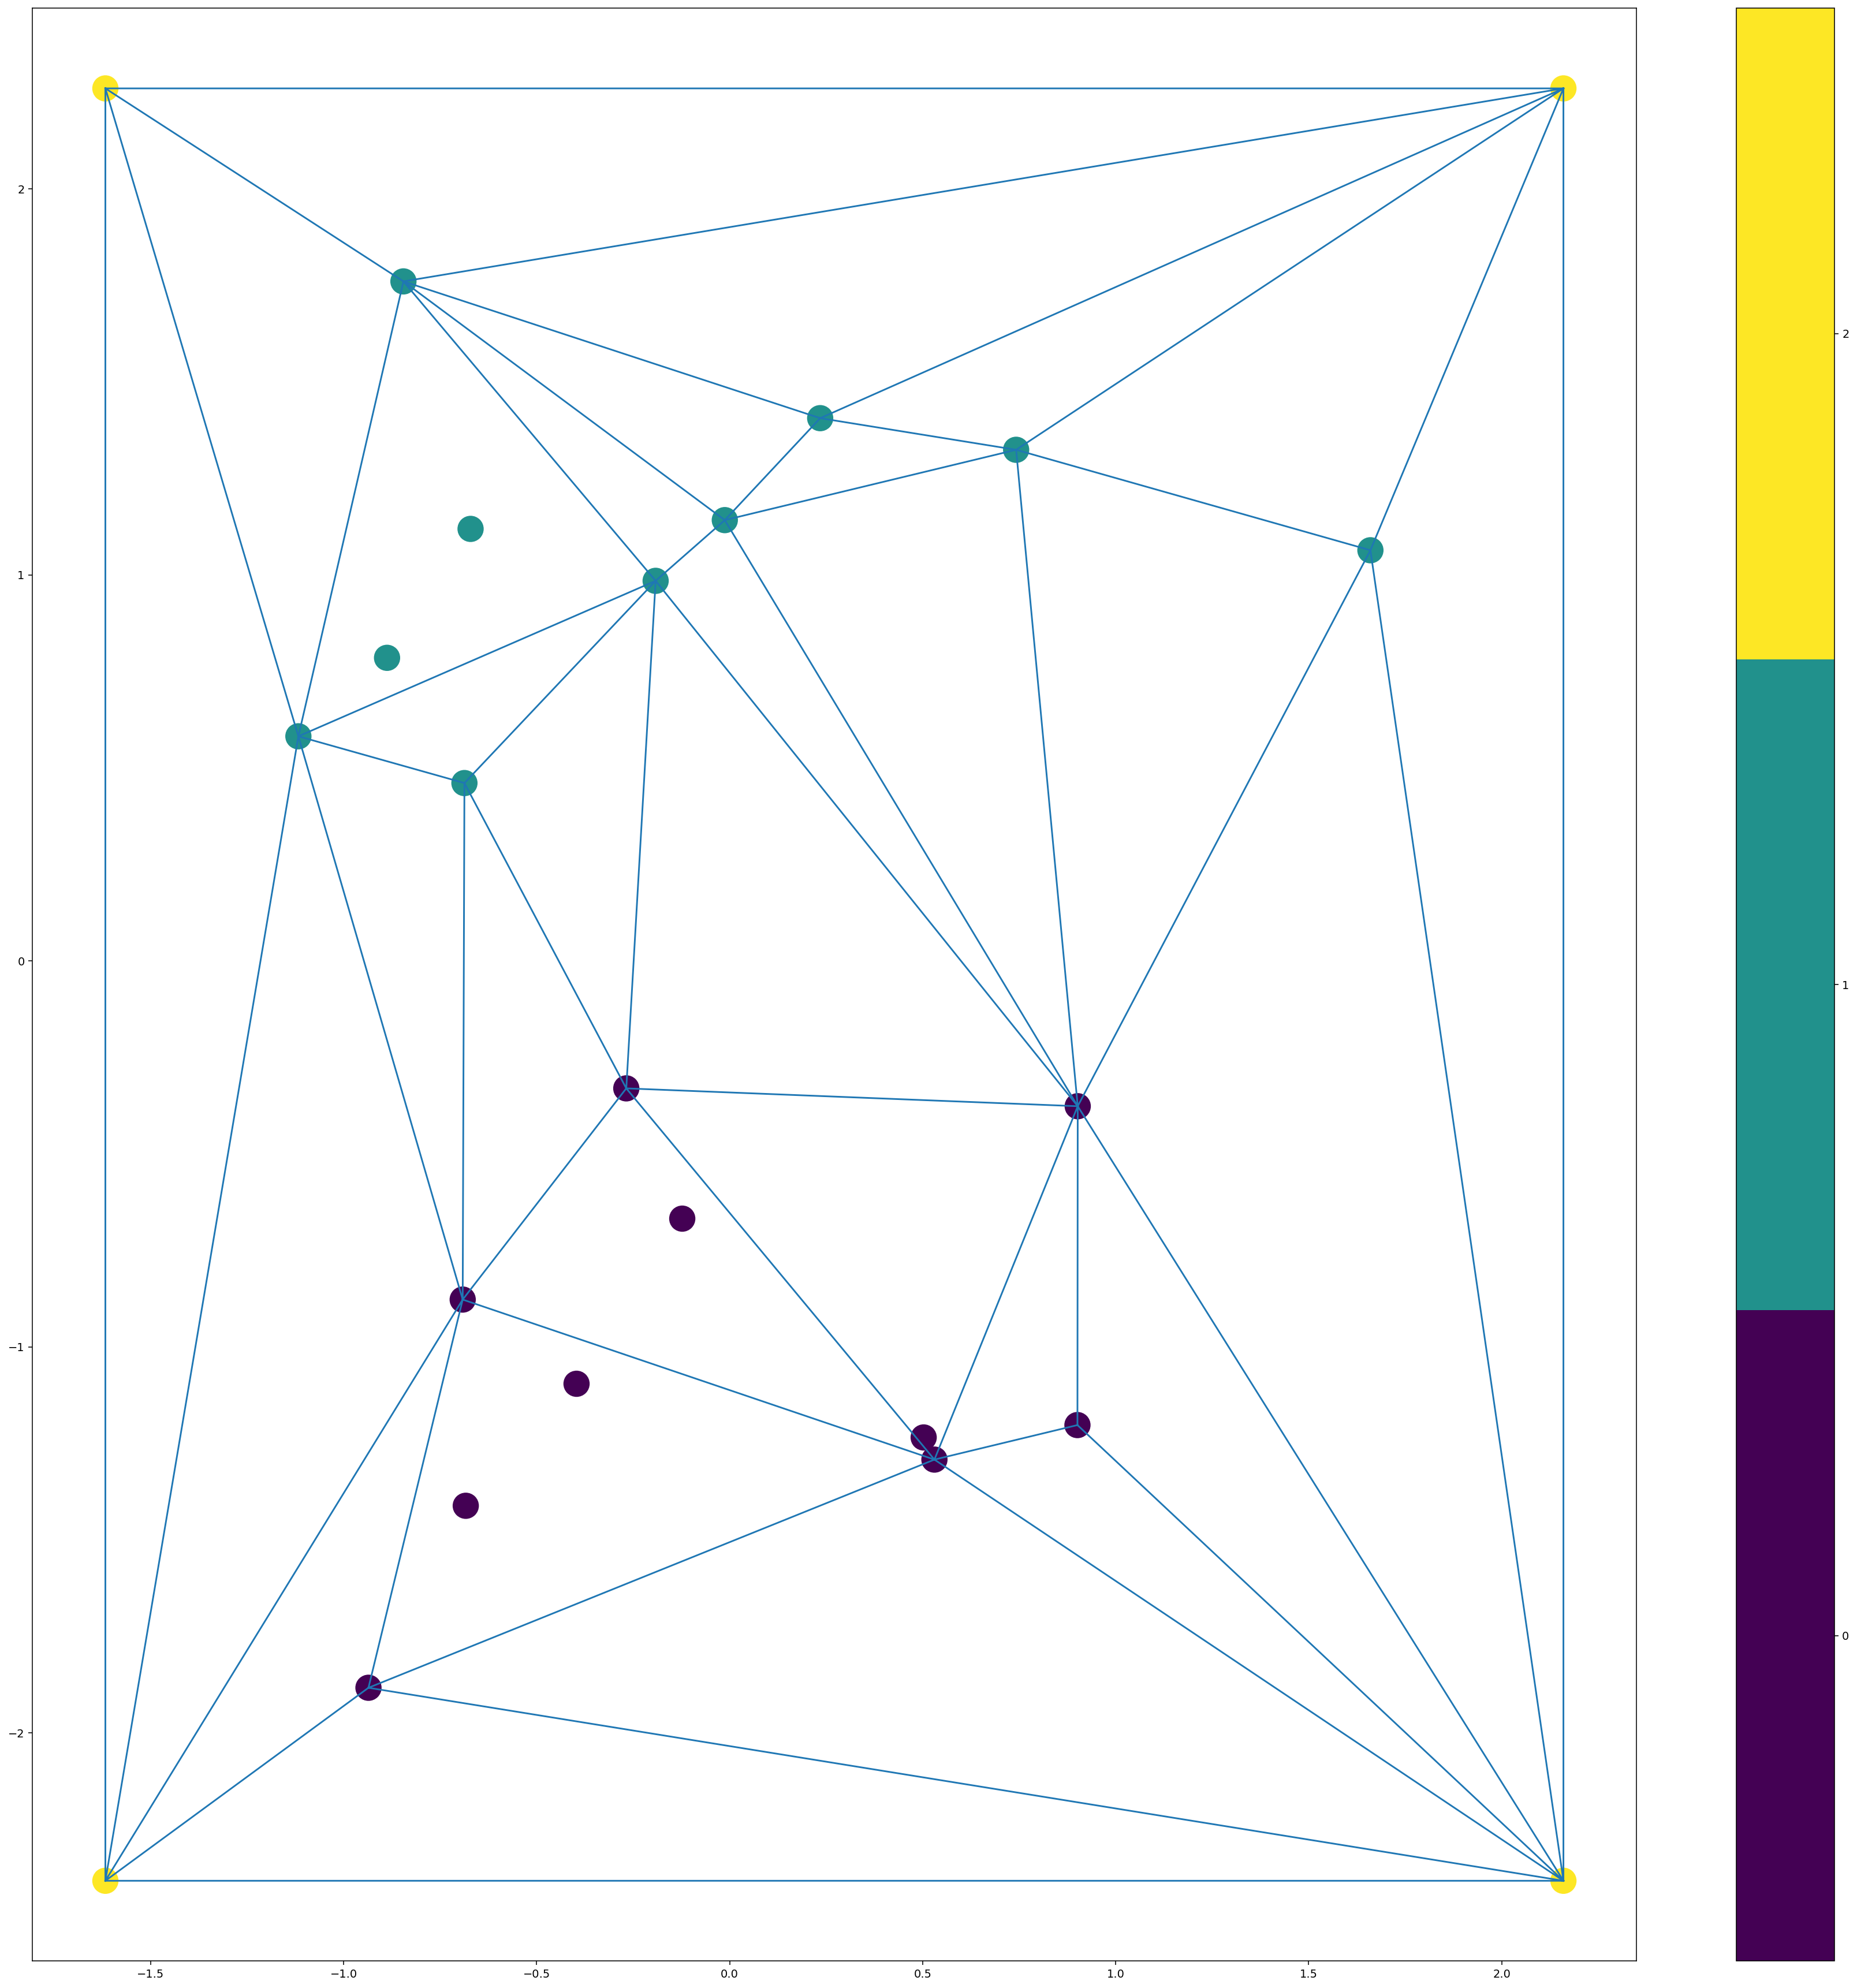

Son  30  triángulos en total.
Son  18  puntos en total.


In [144]:
print("Originalmente eran ",len(k.simplices)," triángulos y ",len(k.points)," puntos.")
pairs = zip(labels[k.simplices],k.simplices)
triangulos=[y for (x,y) in pairs if len(set(x))!=1]
k.simplices=triangulos
puntos=k.points[np.unique(k.simplices)]
labels_puntos = y_total[np.unique(k.simplices)]
tr = Delaunay(puntos)
plt.figure(figsize=(32, 32), dpi=140)
plt.scatter(dataset[:,0],dataset[:,1],c=labels,s=500)
plt.triplot(puntos[:,0], puntos[:,1], tr.simplices)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
plt.show()
print("Son ",len(tr.simplices), " triángulos en total.")
print("Son ",len(tr.points), " puntos en total.")

# Ejemplo en alta dimensión

In [148]:
from sklearn.datasets import load_digits
digits = load_digits()